In [2]:
!pip install ultralytics kagglehub pillow opencv-python-headless -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.4 MB/s eta 0:00:00


In [3]:
import os
import shutil
import kagglehub
from pathlib import Path
import yaml
from PIL import Image
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"awaishashar","key":"f8984e448ae28242479954436f7d8c94"}'}

In [5]:
print("Downloading datasets...")

yawn_dataset_path = kagglehub.dataset_download("davidvazquezcic/yawn-dataset")
print(f"Yawn dataset: {yawn_dataset_path}")

face_dataset_path = kagglehub.dataset_download("fareselmenshawii/face-detection-dataset")
print(f"Face dataset: {face_dataset_path}")

finger_dataset_path = kagglehub.dataset_download("koryakinp/fingers")
print(f"Finger dataset: {finger_dataset_path}")

Using Colab cache for faster access to the 'yawn-dataset' dataset.
Yawn dataset: /kaggle/input/yawn-dataset


100%|██████████| 4.43G/4.43G [00:41<00:00, 115MB/s]

Extracting files...


Face dataset: /root/.cache/kagglehub/datasets/fareselmenshawii/face-detection-dataset/versions/3
Using Colab cache for faster access to the 'fingers' dataset.
Finger dataset: /kaggle/input/fingers


In [6]:
dataset_root = Path("/content/yolo_dataset")
dataset_root.mkdir(exist_ok=True)

for split in ['train', 'val']:
    (dataset_root / split / 'images').mkdir(parents=True, exist_ok=True)
    (dataset_root / split / 'labels').mkdir(parents=True, exist_ok=True)

In [7]:
class_names = {
    0: 'mouth_open',
    1: 'mouth_closed',
    2: 'face',
    3: 'finger'
}

num_classes = len(class_names)

In [8]:
def detect_mouth_bbox(image_path):
    """
    Detect mouth region using face detection and anatomical proportions.
    Returns normalized bbox coordinates [x_center, y_center, width, height].
    """
    try:
        img = cv2.imread(str(image_path))
        if img is None:
            return None

        h, w = img.shape[:2]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        if len(faces) == 0:
            mouth_x_center = 0.5
            mouth_y_center = 0.65
            mouth_width = 0.3
            mouth_height = 0.15
        else:
            fx, fy, fw, fh = faces[0]

            mouth_x = fx + fw * 0.25
            mouth_y = fy + fh * 0.6
            mouth_w = fw * 0.5
            mouth_h = fh * 0.25

            mouth_x_center = (mouth_x + mouth_w / 2) / w
            mouth_y_center = (mouth_y + mouth_h / 2) / h
            mouth_width = mouth_w / w
            mouth_height = mouth_h / h

        return [mouth_x_center, mouth_y_center, mouth_width, mouth_height]
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [9]:
def process_mouth_images(source_dir, class_id, split, max_images=500):
    """
    Process mouth images and create YOLO format labels.
    """
    source_path = Path(source_dir)
    if not source_path.exists():
        print(f"Path not found: {source_dir}")
        return 0

    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    image_files = []
    for ext in image_extensions:
        image_files.extend(list(source_path.glob(f'*{ext}')))
        image_files.extend(list(source_path.glob(f'*{ext.upper()}')))

    image_files = image_files[:max_images]
    processed = 0

    for img_file in tqdm(image_files, desc=f"Processing {class_names[class_id]} ({split})"):
        bbox = detect_mouth_bbox(img_file)
        if bbox is None:
            continue

        new_img_name = f"{class_names[class_id]}_{split}_{processed}{img_file.suffix}"
        new_label_name = f"{class_names[class_id]}_{split}_{processed}.txt"

        img_dest = dataset_root / split / 'images' / new_img_name
        label_dest = dataset_root / split / 'labels' / new_label_name

        shutil.copy(img_file, img_dest)

        with open(label_dest, 'w') as f:
            f.write(f"{class_id} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")

        processed += 1

    return processed

In [10]:
print("Processing mouth open images...")
yawn_train = process_mouth_images(f"{yawn_dataset_path}/yawn", 0, 'train', max_images=400)
yawn_val = process_mouth_images(f"{yawn_dataset_path}/yawn", 0, 'val', max_images=100)

print("Processing mouth closed images...")
no_yawn_train = process_mouth_images(f"{yawn_dataset_path}/no yawn", 1, 'train', max_images=400)
no_yawn_val = process_mouth_images(f"{yawn_dataset_path}/no yawn", 1, 'val', max_images=100)

print(f"Mouth open - Train: {yawn_train}, Val: {yawn_val}")
print(f"Mouth closed - Train: {no_yawn_train}, Val: {no_yawn_val}")

Processing mouth open images...


Processing mouth_open (val): 100%|██████████| 100/100 [00:02<00:00, 42.84it/s]


Processing mouth closed images...


Processing mouth_closed (val): 100%|██████████| 100/100 [00:02<00:00, 47.48it/s]

Mouth open - Train: 400, Val: 100
Mouth closed - Train: 400, Val: 100


In [11]:
def process_yolo_dataset(images_dir, labels_dir, class_id, split, max_images=500):
    """
    Process pre-labeled YOLO format datasets.
    """
    images_path = Path(images_dir)
    labels_path = Path(labels_dir)

    if not images_path.exists() or not labels_path.exists():
        print(f"Path not found: {images_dir} or {labels_dir}")
        return 0

    image_files = list(images_path.glob('*.jpg')) + list(images_path.glob('*.png'))
    image_files = image_files[:max_images]
    processed = 0

    for img_file in tqdm(image_files, desc=f"Processing {class_names[class_id]} ({split})"):
        label_file = labels_path / f"{img_file.stem}.txt"
        if not label_file.exists():
            continue

        new_img_name = f"{class_names[class_id]}_{split}_{processed}{img_file.suffix}"
        new_label_name = f"{class_names[class_id]}_{split}_{processed}.txt"

        img_dest = dataset_root / split / 'images' / new_img_name
        label_dest = dataset_root / split / 'labels' / new_label_name

        shutil.copy(img_file, img_dest)

        with open(label_file, 'r') as f:
            lines = f.readlines()

        with open(label_dest, 'w') as f:
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    f.write(f"{class_id} {parts[1]} {parts[2]} {parts[3]} {parts[4]}\n")

        processed += 1

    return processed

In [12]:
print("Processing face detection images...")
face_train = process_yolo_dataset(
    f"{face_dataset_path}/images/train",
    f"{face_dataset_path}/labels/train",
    2, 'train', max_images=600
)
face_val = process_yolo_dataset(
    f"{face_dataset_path}/images/val",
    f"{face_dataset_path}/labels/val",
    2, 'val', max_images=150
)

print(f"Face - Train: {face_train}, Val: {face_val}")

Processing face detection images...


Processing face (val): 100%|██████████| 150/150 [00:00<00:00, 1714.69it/s]

Face - Train: 600, Val: 150


In [13]:
print("Processing finger detection images...")
finger_train = process_yolo_dataset(
    f"{finger_dataset_path}/train",
    f"{finger_dataset_path}/train",
    3, 'train', max_images=500
)
finger_val = process_yolo_dataset(
    f"{finger_dataset_path}/test",
    f"{finger_dataset_path}/test",
    3, 'val', max_images=125
)

print(f"Finger - Train: {finger_train}, Val: {finger_val}")

Processing finger detection images...


Processing finger (val): 100%|██████████| 125/125 [00:00<00:00, 4256.90it/s]

Finger - Train: 0, Val: 0


In [14]:
train_images = len(list((dataset_root / 'train' / 'images').glob('*')))
val_images = len(list((dataset_root / 'val' / 'images').glob('*')))
train_labels = len(list((dataset_root / 'train' / 'labels').glob('*')))
val_labels = len(list((dataset_root / 'val' / 'labels').glob('*')))

print(f"\nDataset Summary:")
print(f"Train images: {train_images}, labels: {train_labels}")
print(f"Val images: {val_images}, labels: {val_labels}")


Dataset Summary:
Train images: 1400, labels: 1400
Val images: 350, labels: 350


In [15]:
yaml_content = f"""
path: {dataset_root}
train: train/images
val: val/images

nc: {num_classes}
names: {list(class_names.values())}
"""

yaml_path = dataset_root / 'data.yaml'
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"Dataset configuration saved to {yaml_path}")

Dataset configuration saved to /content/yolo_dataset/data.yaml


In [16]:
model = YOLO('yolov8m.pt')
print("YOLOv8m model loaded")

YOLOv8m model loaded


In [17]:
results = model.train(
    data=str(yaml_path),
    epochs=50,
    imgsz=640,
    batch=16,
    name='behavior_detection',
    patience=10,
    save=True,
    device=0,
    workers=4,
    optimizer='AdamW',
    lr0=0.001,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3,
    warmup_momentum=0.8,
    box=7.5,
    cls=0.5,
    dfl=1.5,
    val=True,
    plots=True
)

Ultralytics 8.3.226 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=behavior_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=10, perspective=0.0, plot

In [18]:
metrics = model.val()
print("\nValidation Metrics:")
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")

Ultralytics 8.3.226 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2015.9±1499.5 MB/s, size: 188.7 KB)
val: Scanning /content/yolo_dataset/val/labels.cache... 350 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 350/350 674.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 22/22 2.5it/s 8.9s
                   all        350        633      0.963      0.927      0.955      0.793
            mouth_open        100        100      0.989       0.99      0.989      0.857
          mouth_closed        100        100      0.986       0.99      0.994       0.93
                  face        150        433      0.913      0.801      0.882      0.592
Speed: 1.5ms preprocess, 19.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /content/runs/detect/val

Vali

In [19]:
model_save_path = '/content/behavior_detection_yolov8m.pt'
shutil.copy(model.trainer.best, model_save_path)
print(f"Best model saved to: {model_save_path}")

Best model saved to: /content/behavior_detection_yolov8m.pt


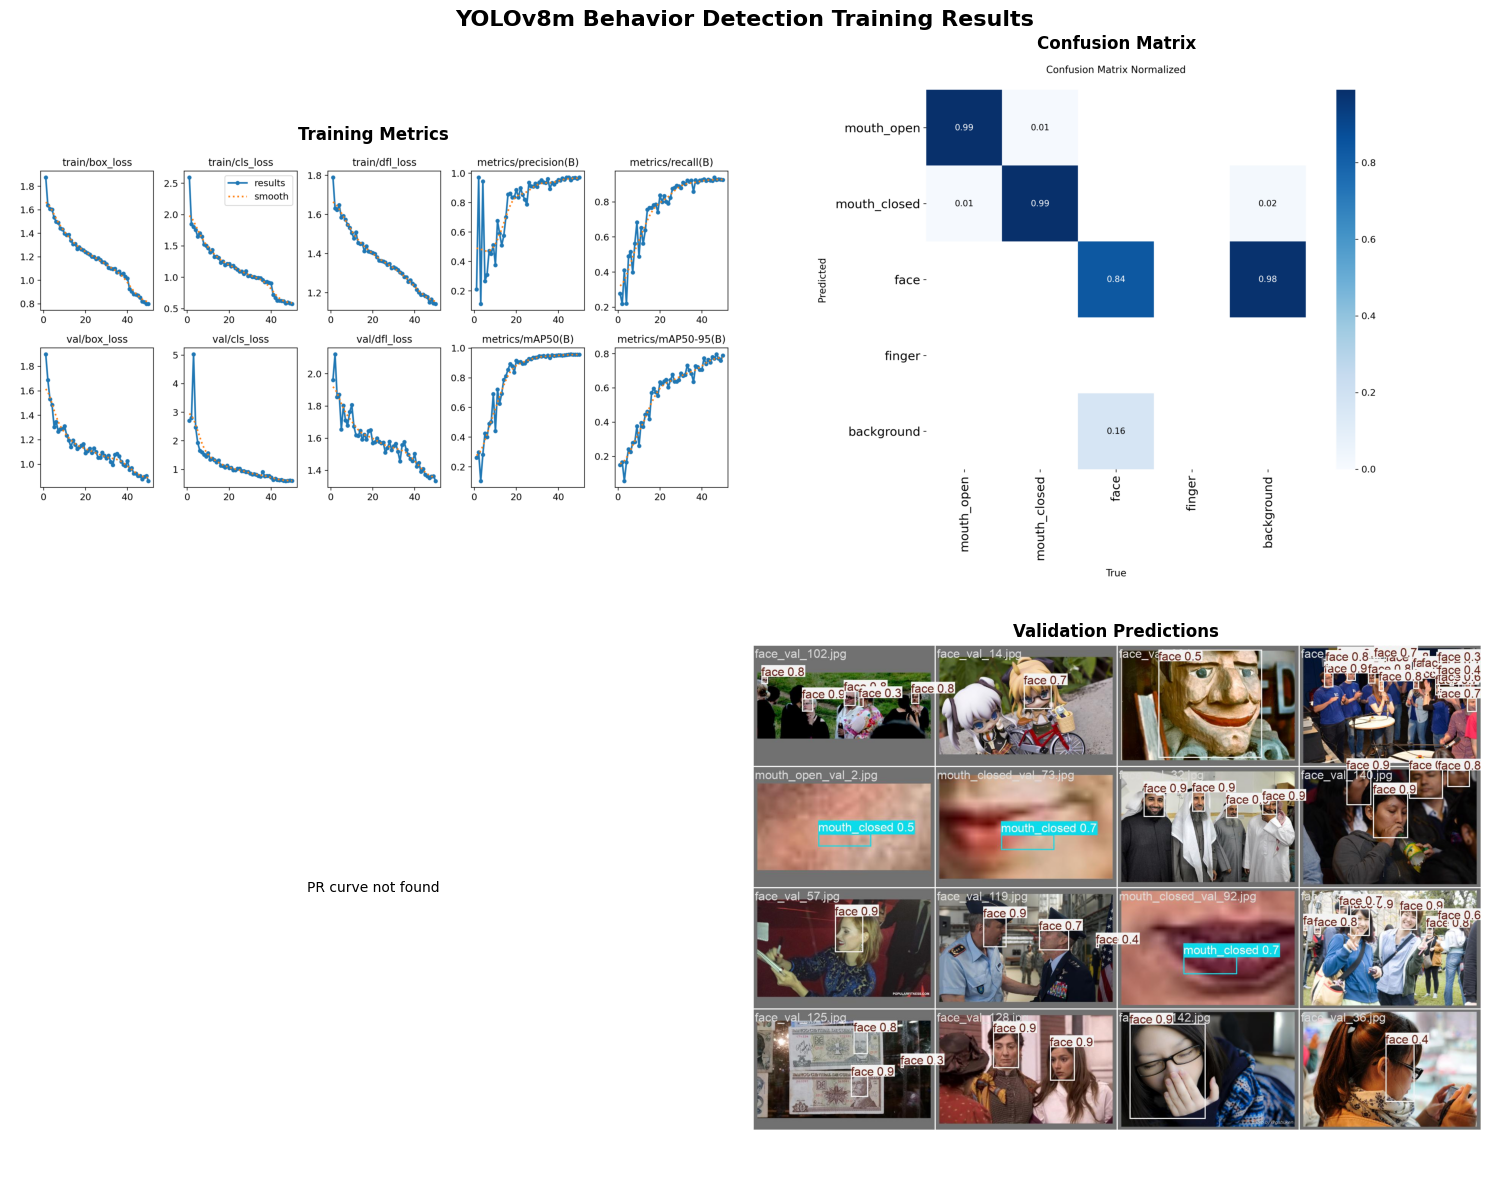


Training visualization saved to: /content/training_summary.png


In [20]:
results_dir = Path(model.trainer.save_dir)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('YOLOv8m Behavior Detection Training Results', fontsize=16, fontweight='bold')

results_img = results_dir / 'results.png'
if results_img.exists():
    img = plt.imread(results_img)
    axes[0, 0].imshow(img)
    axes[0, 0].axis('off')
    axes[0, 0].set_title('Training Metrics', fontsize=12, fontweight='bold')
else:
    axes[0, 0].text(0.5, 0.5, 'Results not found', ha='center', va='center')
    axes[0, 0].axis('off')

confusion_img = results_dir / 'confusion_matrix_normalized.png'
if confusion_img.exists():
    img = plt.imread(confusion_img)
    axes[0, 1].imshow(img)
    axes[0, 1].axis('off')
    axes[0, 1].set_title('Confusion Matrix', fontsize=12, fontweight='bold')
else:
    axes[0, 1].text(0.5, 0.5, 'Confusion matrix not found', ha='center', va='center')
    axes[0, 1].axis('off')

pr_curve_img = results_dir / 'PR_curve.png'
if pr_curve_img.exists():
    img = plt.imread(pr_curve_img)
    axes[1, 0].imshow(img)
    axes[1, 0].axis('off')
    axes[1, 0].set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
else:
    axes[1, 0].text(0.5, 0.5, 'PR curve not found', ha='center', va='center')
    axes[1, 0].axis('off')

val_batch_img = results_dir / 'val_batch0_pred.jpg'
if val_batch_img.exists():
    img = plt.imread(val_batch_img)
    axes[1, 1].imshow(img)
    axes[1, 1].axis('off')
    axes[1, 1].set_title('Validation Predictions', fontsize=12, fontweight='bold')
else:
    axes[1, 1].text(0.5, 0.5, 'Validation batch not found', ha='center', va='center')
    axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('/content/training_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTraining visualization saved to: /content/training_summary.png")

In [22]:
print(f"\nModel saved at: {model_save_path}")
print(f"\nFinal Performance Metrics:")
print(f"  - mAP@0.5: {metrics.box.map50:.4f}")
print(f"  - mAP@0.5:0.95: {metrics.box.map:.4f}")
print(f"  - Precision: {metrics.box.mp:.4f}")
print(f"  - Recall: {metrics.box.mr:.4f}")
print(f"\nClass Performance (mAP@0.5):")
try:
    if hasattr(metrics.box, 'ap_class_index') and hasattr(metrics.box, 'ap'):
        for idx, ap_val in zip(metrics.box.ap_class_index, metrics.box.ap):
            if int(idx) in class_names:
                print(f"  - {class_names[int(idx)]}: {ap_val:.4f}")
    else:
        print(f"  Overall mAP@0.5: {metrics.box.map50:.4f}")
except (AttributeError, IndexError, TypeError):
    print(f"  Overall mAP@0.5: {metrics.box.map50:.4f}")
print(f"\n{'='*60}")
print(f"{'='*60}")


Model saved at: /content/behavior_detection_yolov8m.pt

Final Performance Metrics:
  - mAP@0.5: 0.9551
  - mAP@0.5:0.95: 0.7932
  - Precision: 0.9627
  - Recall: 0.9271

Class Performance (mAP@0.5):
  - mouth_open: 0.8573
  - mouth_closed: 0.9300
  - face: 0.5923

